# Load data

In [10]:
#%matplotlib qt
import numpy as np
import pandas as pd
import os
# import keyboard
import matplotlib.pyplot as plt

from utils import * #ecef_to_llh, llh_to_ecef
from read_user import User
from read_obs import read_real_rover_obs, read_obs_data
from read_base import read_real_base_obs, parse_rinex_observation_data
# from EKF_utils import *


In [11]:
dir_path = os.getcwd()
data =  'RWD_20250422/D1T4' #'RWD_20250422/D1T4' 'YJN\Tightly_coupled_EKF-main' 'RWD_20250422/D2T10'
folder_path = os.path.join(dir_path, data)

''' Get User Position, IMU'''
user = User()
user.read_real_user_data(os.path.join(folder_path, 'user_pos.csv'), os.path.join(folder_path, 'imu_data.csv'))
origin = user.pos_llh[0, :] 

''' Read Base Observations '''
base_obs = read_real_base_obs(os.path.join(folder_path, 'base_obs.csv'))

if 'D1' in data: # h + 45.5
    base_position, base_ecef = [48.0779195, 11.6305769, 549.51], False
    lte_tx1_llh = [48.0780113, 11.6307491, 549.40]
    lte_tx2_llh = [48.0778041, 11.6306888, 549.38]
    pl_tx1_llh = [48.0779030, 11.6309295, 551.38]
    pl_tx2_llh = [48.0781220, 11.6306068, 551.25]

elif 'D2' in data:
    base_position, base_ecef = [48.0779172, 11.6305752, 549.57], False
    lte_tx1_llh = [48.0780048, 11.6307446, 549.40]
    lte_tx2_llh = [48.0777902, 11.6306752, 549.42]
    pl_tx1_llh  = [48.0778883, 11.6309177, 551.56]
    pl_tx2_llh  = [48.0781255, 11.6306180, 551.40]
else:
    print("\033[31mError\033[0m: No transmitter data available for this dataset.")

lte_tx1_ecef = llh_to_ecef([lte_tx1_llh])[0]
lte_tx2_ecef = llh_to_ecef([lte_tx2_llh])[0]
pl_tx1_ecef = llh_to_ecef([pl_tx1_llh])[0]
pl_tx2_ecef = llh_to_ecef([pl_tx2_llh])[0]
TX_POS = {'L01': lte_tx1_ecef, 'L02': lte_tx2_ecef, 'P47': pl_tx1_ecef, 'P48': pl_tx2_ecef}

''' Read Rover Observations '''
rover_gnss = read_real_rover_obs(os.path.join(folder_path, 'rover_obs.csv'), TX_POS)

# print(pd.read_csv(os.path.join(folder_path, 'rover_obs_crop.csv'))['id'].unique())
# print(pd.read_csv(os.path.join(folder_path, 'rover_obs_crop.csv'))['sv_id'].unique())

# Get same time
np.set_printoptions(precision=10, suppress=False)
user_times = np.round(np.asarray(user.user['gps_time'].values, dtype=float), 1)
rover_obs_time = np.round(np.array(list(rover_gnss.keys()), dtype=float), 1)
overlapped_time, idx1, idx2 = np.intersect1d(user_times, rover_obs_time, return_indices=True)
# print(user_times[:10])
# print(rover_obs_time[:10])
# print(overlapped_time)
print(len(idx1), len(idx2))
print(max(user_times) - min(user_times), max(rover_obs_time) - min(rover_obs_time))
print("User time range:", min(user_times), max(user_times))
print("Rover time range:", min(rover_obs_time), max(rover_obs_time))
print("Overlapped time range:", min(overlapped_time), max(overlapped_time))

716 716
111.0 83.10000014305115
User time range: 1429364521.4 1429364632.4
Rover time range: 1429364549.3 1429364632.4
Overlapped time range: 1429364549.3 1429364632.4


In [12]:
unique_ids = {obs.id for obs_list in rover_gnss.values() for obs in obs_list}
print(sorted(unique_ids))

# print(user.user['gps_time'].values[:50]/1e9)


['E05', 'E09', 'E15', 'E18', 'E21', 'E27', 'E30', 'E34', 'E36', 'G01', 'G02', 'G08', 'G10', 'G15', 'G16', 'G23', 'G27', 'G32', 'L01', 'L02', 'P47', 'P48']


In [13]:
ele_mask = 20

'''Single Difference Pseudorange Calculation for all Observations'''
obs_id_no_base = {}
gps_estimated = {}
for key, obs_list in rover_gnss.items():

    key = round(float(key), 1)
    
    data_obs, sat_positions, pseudoranges = [], [], [] # for gps only solution

    base_times = list(base_obs.keys())
    closest_time = min(base_times, key=lambda t: abs(t - key))

    bs_ids = [b.id for b in base_obs[closest_time]]
    for obs in obs_list:
        if obs.id in bs_ids:
            obs.calculate_pseudorange_single_diff(
                base_obs[closest_time][bs_ids.index(obs.id)].pseudorange,
                base_position
            )

            if key in overlapped_time:
                # print(key)
                i = np.where(overlapped_time == key)[0][0]
                obs.calculate_azimuth_elevation(user.pos_ecef[idx1[i]])
                if 'G' in obs.id and obs.elevation > ele_mask: #For GPS only solution
                    data_obs.append(obs)
                    sat_positions.append(obs.satellite_pos)
                    pseudoranges.append(obs.pseudorange_single_diff)
                    # continue
            # else:
            #     print(key)

            if ('P' not in obs.id and 'L' not in obs.id):
                obs.pseudorange_nav = obs.pseudorange_single_diff

        else:
            if obs.id not in obs_id_no_base:
                obs_id_no_base[obs.id] = []
            obs_id_no_base[obs.id].append(key)
    
    if len(pseudoranges) >= 4:
        receiver_position, clock_bias = single_point_positioning(
            sat_positions, pseudoranges, np.append(user.pos_ecef[0], 100)) 
        if key not in gps_estimated:
            gps_estimated[key] = {}
        gps_estimated[key]['estimated_ecef'] = receiver_position
        gps_estimated[key]['estimated_cb'] = clock_bias
        gps_estimated[key]['data_obs'] = data_obs
        

print("Obs not in base:", {k: len(v) for k, v in obs_id_no_base.items()})

Obs not in base: {'G15': 710, 'E21': 264, 'E09': 194, 'E36': 11, 'E18': 10}


In [14]:
def correct_code_ambiguity(pseudorange, id, receiver_clock_bias):
    """
    Correct LTE or PL pseudorange ambiguity.

    Parameters:
        pseudorange (float): Raw pseudorange measurement in meters
        beacon_type (int): 76 (LTE) or 80 (PL)
        receiver_clock_bias (float): Clock bias in meters

    Returns:
        float: Corrected pseudorange
    """
    C = 299792458  # speed of light [m/s]

    if 'L' in id:  # LTE
        half_code_period = 0.005
    elif 'P' in id:
        half_code_period = 0.002
    else:
        return pseudorange  # No correction needed for GNSS or unknown type

    ambiguity = np.floor(pseudorange / (C * half_code_period)) - np.floor(receiver_clock_bias / (C * half_code_period))
    return pseudorange - C * half_code_period * ambiguity


In [15]:

# print(gps_estimated.keys())
# for key, obs_list in gps_estimated.items():
#     print(key, obs_list['estimated_ecef'], obs_list['estimated_cb'])

'''Correct Code Ambiguity for LTE and PL using the Estimated Clock Bias'''

for key, obs_list in rover_gnss.items():
    key = round(float(key), 1)
    for obs in obs_list:
        if ('P' not in obs.id and 'L' not in obs.id) or (key not in gps_estimated):
            continue
        if obs.pseudorange_single_diff is not None:
            obs.pseudorange_nav = correct_code_ambiguity(obs.pseudorange_single_diff, obs.id, gps_estimated[key]['estimated_cb'])
        else:
            obs.pseudorange_nav = correct_code_ambiguity(obs.pseudorange, obs.id, gps_estimated[key]['estimated_cb'])

# for key, obs_list in rover_gnss.items():
#     for obs in obs_list:
#         print(obs.pseudorange_single_diff, obs.pseudorange_nav, obs.id, obs.satellite_pos, obs.elevation)

In [16]:
CASES = {
    0: ['C', 'E', 'P', 'L'],
    5: [],
    11: ['C', 'E', 'L'],
    12: ['C', 'E', 'P'],
}

'''Get the results for Different Cases'''
results = {}
for i, exclude_id in CASES.items():
    print(f"\n--- Case {i}: Exclude {exclude_id} ---")

    estimated_ecef, estimated_cb, data = {}, {}, {}
    for key, obs_list in rover_gnss.items():

        key = round(float(key), 1)
        data_obs, sat_positions, pseudoranges = [], [], [] # for gps only solution
        
        for obs in obs_list:
            if obs.pseudorange_nav is None:
                continue
            if any(ex_id in obs.id for ex_id in exclude_id):
                continue
            data_obs.append(obs)
            sat_positions.append(obs.satellite_pos)
            pseudoranges.append(obs.pseudorange_nav)
        
        if len(pseudoranges) >= 4:
            receiver_position, clock_bias = single_point_positioning(
                sat_positions, pseudoranges, np.append(user.pos_ecef[0], 100)) 
        
            estimated_ecef[key] = receiver_position
            estimated_cb[key] = clock_bias
            data[key] = data_obs
    
    # user_times = np.round(np.asarray(user.user['gps_time'].values, dtype=float), 1)
    # rover_obs_time = np.round(np.array(list(rover_gnss.keys()), dtype=float), 1)
    # print(np.array(list(data.keys())))
    overlapped_time, idx1, idx2 = np.intersect1d(user_times, np.array(list(data.keys())), return_indices=True)
    estimated_enu = {
            k: llh_to_enu(ecef_to_llh([v]), origin)
            for k, v in estimated_ecef.items() }
    
    results[i] = {
        'estimated_ecef': estimated_ecef, 
        'estimated_cb': estimated_cb,
        'estimated_enu': estimated_enu,
        'data': data,
        'idx1': idx1, # User time indices
        'idx2': idx2 # GNSS time indices
    }


            



--- Case 0: Exclude ['C', 'E', 'P', 'L'] ---

--- Case 5: Exclude [] ---

--- Case 11: Exclude ['C', 'E', 'L'] ---

--- Case 12: Exclude ['C', 'E', 'P'] ---


Results for case 0:
Estimated ECEF positions: 810
2D Error in enu: 3.263112739310447
3D Error in enu: 5.066412514486875


Results for case 5:
Estimated ECEF positions: 832
2D Error in enu: 6.416097354615117
3D Error in enu: 8.060910175487447


Results for case 11:
Estimated ECEF positions: 810
2D Error in enu: 3.3439549340638486
3D Error in enu: 4.021101372827755


Results for case 12:
Estimated ECEF positions: 810
2D Error in enu: 2.2275390818619445
3D Error in enu: 3.4056923646841795




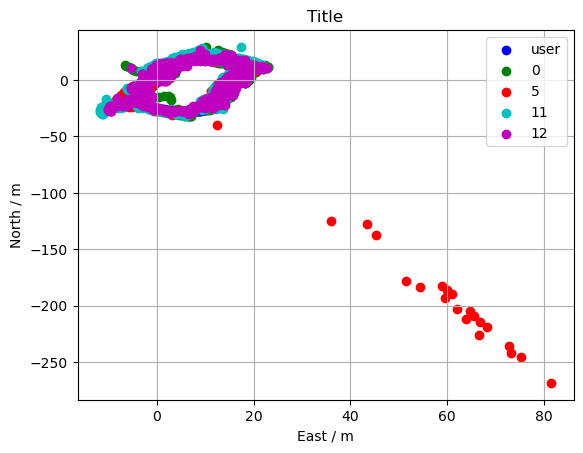

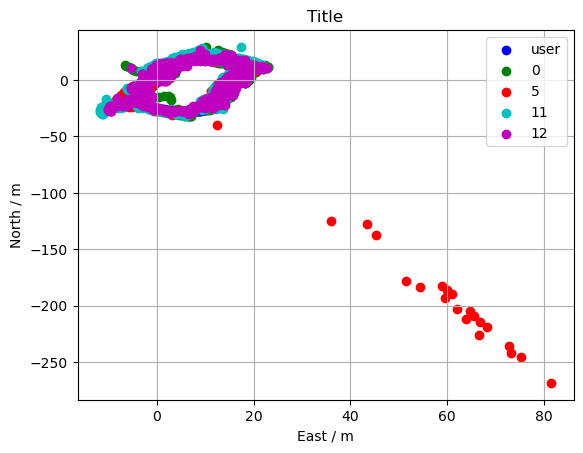

In [17]:
user_enu = llh_to_enu(user.pos_llh, origin)

%matplotlib inline
for i in results.keys():
    print(f"Results for case {i}:")
    print(f"Estimated ECEF positions: {len(results[i]['estimated_ecef'])}")
    keys = list(results[i]['estimated_enu'].keys())
    enu_array = np.array([np.squeeze(results[i]['estimated_enu'][k]) for k in keys])
    error = np.linalg.norm(enu_array[results[i]['idx2'], :2] - user_enu[results[i]['idx1'], :2], axis=1)
    print("2D Error in enu:", np.mean(error))
    error = np.linalg.norm(enu_array[results[i]['idx2'], :] - user_enu[results[i]['idx1'], :], axis=1)
    print("3D Error in enu:", np.mean(error))
    print("\n")

# plot_trajectory({'user': user_enu, **{i: results[i]['estimated_enu'] for i in results.keys()}}, 'Title', 'enu', twoD=True, scatter=True)
plot_trajectory(
    {'user': user_enu,
        **{i: np.array([np.squeeze(v) for v in results[i]['estimated_enu'].values()])
            for i in results.keys()} },
    'Title', 'enu', twoD=True, scatter=True
)


# plt.xlim(-25, 25)  
# plt.ylim(-50, 50) 
# plt.xlim(-500, 500)  
# plt.ylim(-500, 500) 
# plt.xlim(-5000, 5000)  
# plt.ylim(-5000, 5000) 
# plt.xlim(-50, 50)  
# plt.ylim(21250, 21300) 
# plt.xlim(500000, 520000)  
# plt.ylim(50000, 100000) 
plt.show()

#%matplotlib qt
# plot_trajectory({'user': user_enu, **{i: np.array([np.squeeze(v) for v in results[i]['estimated_enu'].values()])
#             for i in results.keys()}}, 'Title', 'enu', twoD=True, scatter=True)
plot_trajectory(
    {'user': user_enu,
        **{i: np.array([np.squeeze(v) for v in results[i]['estimated_enu'].values()])
            for i in results.keys()} },
    'Title', 'enu', twoD=True, scatter=True
)

plt.show()


In [18]:
'''Save results to CSV for learning'''
file_path = os.path.join(folder_path, 'observation_data_case5_1.csv')
# Get Residual and Pseudorange Corrected - Clock Bias
Case_for_learning = 5
Case_ecef = results[Case_for_learning]['estimated_ecef']
Case_cb = results[Case_for_learning]['estimated_cb']

all_obs_data = []
for key, obs_list in results[Case_for_learning]['data'].items():
    key = round(float(key), 1)

    for obs in obs_list:
        # if obs.id in ['L01', 'L02', 'P47', 'P48']:
        #     print(obs.id)
        #     print(np.linalg.norm(np.array(obs.satellite_pos) - np.array(Case_ecef[key])))
        #     print(obs.pseudorange_nav-Case_cb[key])
        #     obs.calculate_pseudorange_residual(Case_ecef[key], Case_cb[key], obs.pseudorange_nav)
        #     print(obs.pseudorange_residual)
        # else:
        obs.calculate_pseudorange_residual(Case_ecef[key], Case_cb[key], obs.pseudorange_nav)

        all_obs_data.append({
            'gps_time': key,
            'satellite_id': obs.id,
            'sv_id': obs.sv_id,
            'pseudorange': obs.pseudorange,
            'doppler_shift': obs.doppler_shift,
            'cn0': obs.CN0,
            'azimuth': obs.azimuth,
            'elevation': obs.elevation,
            'pseudorange_residual': obs.pseudorange_residual,
            'pseudorange_corrected_cb': obs.pseudorange_nav - Case_cb[key],
            'sat_px': obs.satellite_pos[0],
            'sat_py': obs.satellite_pos[1],
            'sat_pz': obs.satellite_pos[2],
        })

# Convert the list of dictionaries to a DataFrame and save it as a CSV file
pd.DataFrame(all_obs_data).to_csv(file_path, index=False)
print(f"Obseration data has been saved to {file_path}")

Obseration data has been saved to c:\Users\yangj\Desktop\4JYY\4JYY\RWD_20250422/D1T4\observation_data_case5_1.csv
